# Проект -  Разработка A/B-тестирования и анализ результатов


Автор: Ольга Бушмина

Дата: 9 апреля 2025

## Введение
Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Предоставлены три таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

## Что нужно сделать
Необходимо рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

Основная метрика, изменение которой ожидается в ходе проведения А/В-теста - доля сессий с четырьмя и более просмотренными страницами (так называемых "успешных" сессий).

Предполагается, что внедрение нового алгоритма рекомендаций **повысит долю успешных сессий** относительно группы пользователей без нового алгоритма.

Дополнительно стоит отслеживать отсутствие изменения числа сессий в день.


### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения:
считаем и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

In [28]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Выгружаем данные в датафрейм
df_sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

# Выводим первые строки датафрейма
display(df_sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий.

In [3]:
# Расчет количества уникальных сессий на пользователя
user_sessions_count = df_sessions_history.groupby('user_id')['session_id'].nunique()

# Пользователь с наибольшим количеством сессий
user_max = user_sessions_count.idxmax()

# Отбираем данные по пользователю
user_max_sessions = df_sessions_history[df_sessions_history['user_id'] == user_max]

display(user_max_sessions)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты будем считать, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [4]:
# Рассчитываем количество уникальных и зарегистрированных пользователей по дням
df_users_daily = df_sessions_history.groupby('session_date').agg(
    unique_users=('user_id', 'nunique'),
    registered_users=('registration_flag', 'sum')
).reset_index()

display(df_users_daily.head(5))

,session_date,unique_users,registered_users
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840


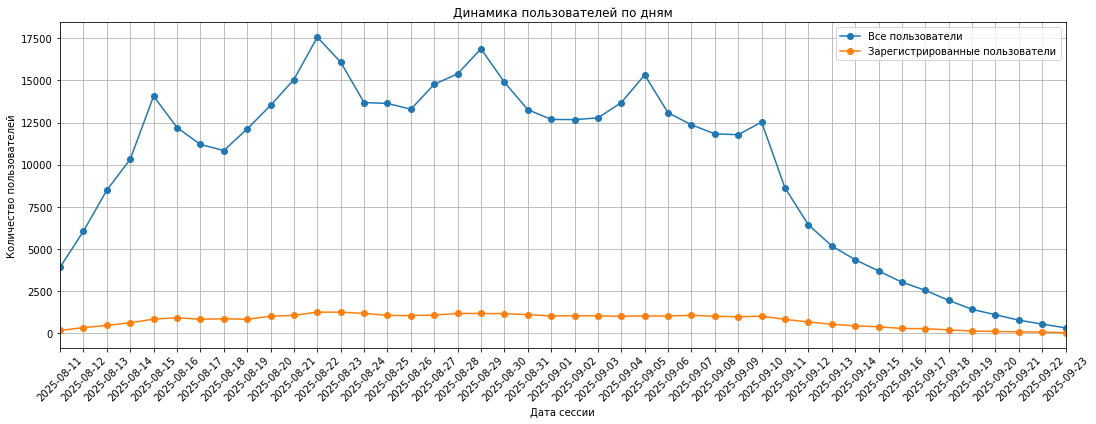

In [5]:
# Строим график
plt.figure(figsize=(15, 6))

# Общее количество пользователей
plt.plot(df_users_daily['session_date'], df_users_daily['unique_users'], label='Все пользователи', marker='o')

# Количество зарегистрированных пользователей
plt.plot(df_users_daily['session_date'], df_users_daily['registered_users'], label='Зарегистрированные пользователи', marker='o')

# Добавляем подписи
plt.title('Динамика пользователей по дням')
plt.xlabel('Дата сессии')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(['2025-08-11','2025-09-23'])
plt.show()

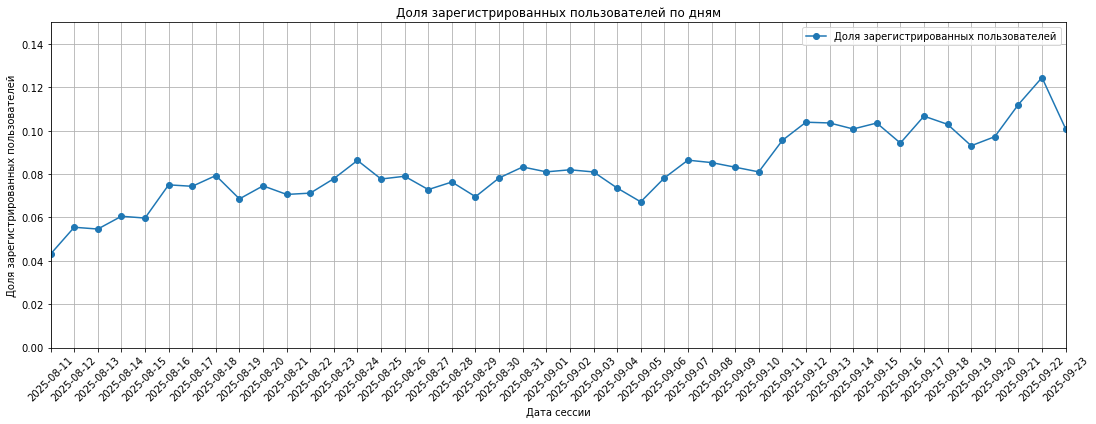

In [6]:
# Рассчитываем долю зарегистрированных пользователей от всех пользователей по дням
df_users_daily['registered_rot'] = df_users_daily['registered_users'] / df_users_daily['unique_users']

# Строим график
plt.figure(figsize=(15, 6))
plt.plot(df_users_daily['session_date'], df_users_daily['registered_rot'], label='Доля зарегистрированных пользователей', marker='o')

plt.title('Доля зарегистрированных пользователей по дням')
plt.xlabel('Дата сессии')
plt.ylabel('Доля зарегистрированных пользователей')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0, 0.15)
plt.grid(True)
plt.tight_layout()
plt.xlim(['2025-08-11','2025-09-23'])
plt.show()

**Вывод:** Число посетителей менялось в течение срока наблюдения от 200 до 17500 человек. В последние 12 дней наблюдений только уменьшалось. При этом доля зарегистрированных пользователей значительно более стабильна во времени.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.


In [7]:
# Определяем количество сессий для каждого значения просмотренных страниц
df_page_count = df_sessions_history.groupby('page_counter')['session_id'].count().reset_index()
df_page_count.columns = ['page_counter', 'session_count']
display(df_page_count)

,page_counter,session_count
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


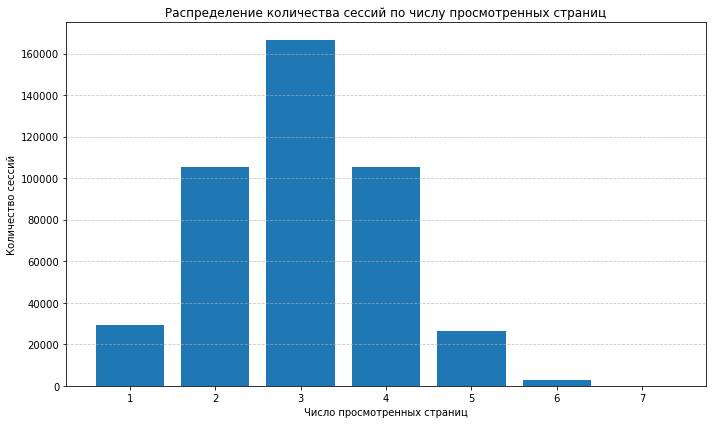

In [8]:
# Построение диаграммы
plt.figure(figsize=(10, 6))
plt.bar(df_page_count['page_counter'], df_page_count['session_count'])

plt.title('Распределение количества сессий по числу просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

**Вывод:** распределение количества сессий по числу просмотренных страниц имеет близкий к нормальному вид. Наибольшее количество людей за сессию просматривает 3 страницы, меньшее количество - по 2 или 4 страницы.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [9]:
# Добавляем столбец по условию
df_sessions_history['good_session'] = (df_sessions_history['page_counter'] >= 4).astype(int)

display(df_sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


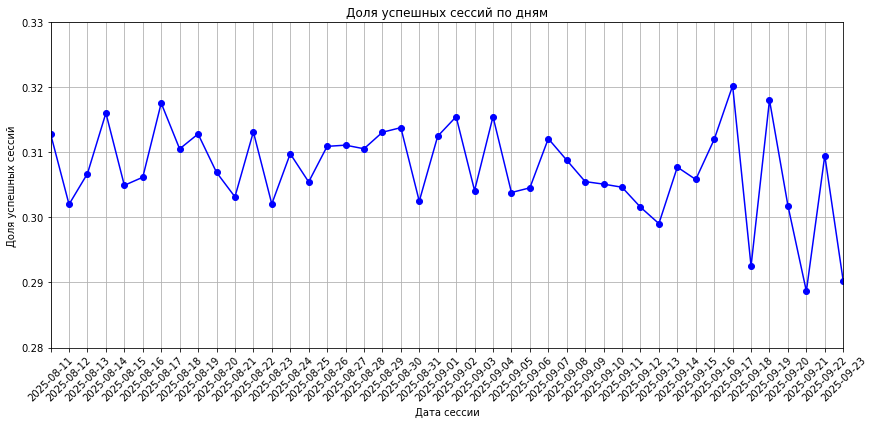

In [10]:
# Строим график
daily_good_sessions = df_sessions_history.groupby('session_date')['good_session'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_good_sessions['session_date'], daily_good_sessions['good_session'], color='blue', marker='o')

plt.title('Доля успешных сессий по дням')
plt.xlabel('Дата сессии')
plt.ylabel('Доля успешных сессий')

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.ylim(0.28,0.33)
plt.xlim(['2025-08-11','2025-09-23'])
plt.show()

**Вывод:** доля успешных сессий (когда за одну сессию было просмотрено 4 и более страниц) довольна стабильна во времени и колеблется вокруг значения 0.31. Однако стоит отметить, что в последние 8 дней наблюдения размах значения увеличился: от 0.29 до 0.32.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
Рассчитаем необходимое для нашего дизайна эксперимента количество пользователей.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.


In [11]:
# Задаём параметры
alpha = 0.05 # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Рассчитаем длительность теста, используя данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. 

In [12]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = df_users_daily['unique_users'].mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(int(sample_size)/avg_daily_users)*2

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дней


**Вывод:** для набора двух экспериментальных групп, в каждой по 17441 человек, потребуется 4 дня.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем процентную разницу в количестве пользователей в группах A и B. Визуализируем возможное различие двух групп.


In [13]:
# Выгружаем данные в датафрейм
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Выводим первые строки датафрейма
display(sessions_test_part.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [14]:
# Выбираем первый день выборки
first_day = sessions_test_part['session_date'].min()

# Фильтруем по первому дню
sessions_one_day = sessions_test_part[sessions_test_part['session_date'] == first_day]

# Считаем уникальных пользователей по группам
users_per_group = sessions_one_day.groupby('test_group')['user_id'].nunique().reset_index()
users_per_group.columns = ['test_group', 'unique_users']

display(users_per_group)

,test_group,unique_users
0,A,1477
1,B,1466


In [15]:
# Считаем количество пользователей в каждой группе
group_counts = sessions_one_day.groupby('test_group')['user_id'].nunique()

A = group_counts['A']
B = group_counts['B']

# Считаем процентную разницу в количестве пользователей 
P = 100 * abs(A - B) / A
print(f"Процентная разница между группами A и B: {P:.2f}%")

Процентная разница между группами A и B: 0.74%


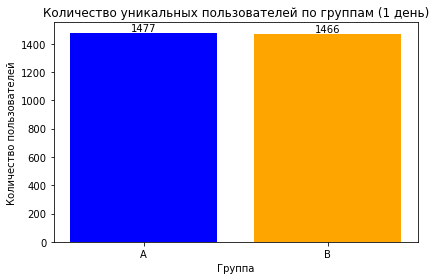

In [16]:
# Строим столбчатую диаграмму
plt.figure(figsize=(6, 4))
plt.bar(group_counts.index, group_counts.values, color=['blue', 'orange'])
plt.title('Количество уникальных пользователей по группам (1 день)')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')

# Подписываем значения
for i, val in enumerate(group_counts.values):
    plt.text(i, val + 1, str(val), ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Вывод:** рассчитано количество пользователей в каждой группе за первый день - 1477(А) и 1466(В), процентная разница составляет 0.74%. Большой разницы между группами не наблюдается, тест идет корректно.

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B.

In [17]:
# Множества пользователей по группам
set_A = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique())
set_B = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique())

# Находим пересечение
users_in_both = set_A.intersection(set_B)

print(f"Количество пользователей, состоящих в обеих группах: {len(users_in_both)}")

Количество пользователей, состоящих в обеих группах: 0


**Вывод.** Согласно расчету нет пользователей, которые попали в обе группы сразу. Значит принцип независимости групп соблюден, тест идет корректно.

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.



In [18]:
# Строим сводную таблицу
pivot = sessions_test_part.pivot_table(
    index='device',
    columns='test_group',
    values='user_id',
    aggfunc='nunique',
    fill_value=0
)
# Переводим абсолютные значения в доли
pivot_norm = pivot.div(pivot.sum(axis=0), axis=1)

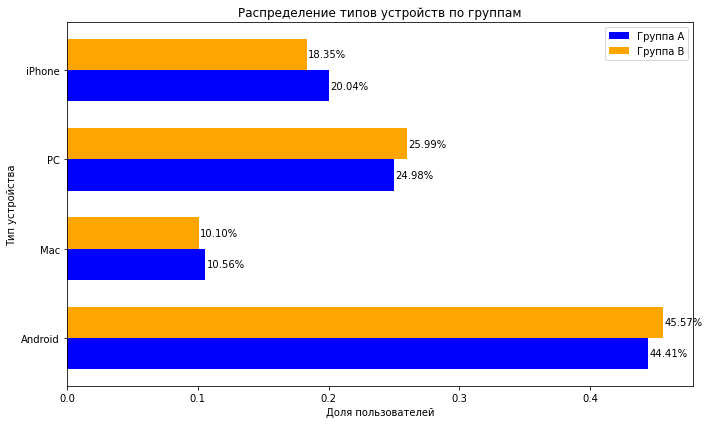

In [19]:
# Подготовка данных
device_labels = pivot_norm.index.tolist()
values_a = pivot_norm['A'].values
values_b = pivot_norm['B'].values

index = np.arange(len(device_labels))
bar_height = 0.35

# Построение диаграммы
plt.figure(figsize=(10, 6))
plt.barh(index, values_a, bar_height, label='Группа A', color='blue')
plt.barh(index + bar_height, values_b, bar_height, label='Группа B', color='orange')

# Оформление графика
plt.ylabel('Тип устройства')
plt.xlabel('Доля пользователей')
plt.title('Распределение типов устройств по группам')
plt.yticks(index + bar_height / 2, device_labels)
plt.legend()

# Подписи над столбцами
for i in range(len(device_labels)):
    plt.text(values_a[i] + 0.001 , i, f"{values_a[i]:.2%}", va='center')
    plt.text(values_b[i] + 0.001, i + bar_height, f"{values_b[i]:.2%}", va='center')

plt.tight_layout()
plt.show()


**Вывод:** согласно данным построенных диаграмм типы устройств распределены по тестовым группы равномерно - разница между группами не превышает 1.5%, тест идет корректно.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.


In [20]:
# Строим сводную таблицу
pivot_region = sessions_test_part.pivot_table(
    index='region',
    columns='test_group',
    values='user_id',
    aggfunc='nunique',
    fill_value=0
)
display(pivot_region)
# Переводим абсолютные значения в доли
pivot_region_norm = pivot_region.div(pivot_region.sum(axis=0), axis=1)

test_group,A,B
region,,
CIS,644,645
EU,224,217
MENA,609,604


In [21]:
# Подготовка данных
region_labels = pivot_region_norm.index.tolist()
values_a_reg = pivot_region_norm['A'].values
values_b_reg = pivot_region_norm['B'].values

index_reg = np.arange(len(region_labels))
bar_width = 0.35

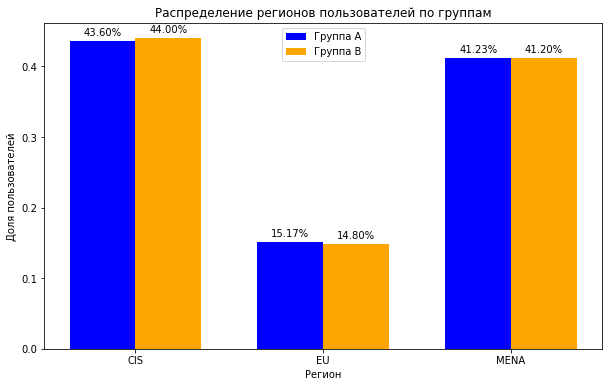

In [22]:
# Построение диаграммы
plt.figure(figsize=(10, 6))
plt.bar(index_reg, values_a_reg, bar_width, label='Группа A', color='blue')
plt.bar(index_reg + bar_width, values_b_reg, bar_width, label='Группа B', color='orange')

# Оформление графика
plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
plt.title('Распределение регионов пользователей по группам')
plt.xticks(index_reg + bar_width / 2, region_labels)
plt.legend()

# Подписи над столбцами
for i in range(len(region_labels)):
    plt.text(i, values_a_reg[i] + 0.005, f"{values_a_reg[i]:.2%}", ha='center', va='bottom')
    plt.text(i + bar_width, values_b_reg[i] + 0.005, f"{values_b_reg[i]:.2%}", ha='center', va='bottom')

plt.show()

**Вывод:** согласно данным построенных диаграмм регионы представлены достататочно равномерно в текстовых группах, тест идет корректно.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируем выводы:

* количество пользователей в каждой группе за первый день - 1477(А) и 1466(В), процентная разница составляет 0.74%
* нет пользователей, которые попали в обе группы сразу, принцип независимости групп соблюден
* равномерное распределение пользователей тестовой и контрольной групп по устройствам и регионам соблюдено

Таким образом можно сделать вывод, что A/B-тест проходит корректно.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [23]:
# Выгружаем данные в датафрейм
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Добавляем столбец по условию
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

# Выводим первые строки датафрейма
display(sessions_test.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будем сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

In [24]:
# Группируем по дате и группе, считаем количество уникальных session_id
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().unstack()

daily_sessions.head()

test_group,A,B
session_date,,
2025-10-14,1502,1628
2025-10-15,2235,2283
2025-10-16,3280,3241
2025-10-17,4089,4054
2025-10-18,5013,5059


Сформулируем гипотезы, которые позволят проверить, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. 

**H₀ (нулевая гипотеза):**
* Среднее количество уникальных сессий по дням одинаково в группах A и B.

**H₁ (альтернативная гипотеза):**
* Среднее количество уникальных сессий по дням различается между группами A и B.


In [25]:
# Получаем данные по каждой группе
sessions_A = daily_sessions['A']
sessions_B = daily_sessions['B']

# Применяем t-тест
stat, p_value = ttest_ind(sessions_A, sessions_B, equal_var=False)

# Вывод результата
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Статистически значимые различия есть — среднее количество сессий в группах A и B различается.")
else:
    print("Статистически значимых различий нет — распределение сессий в группах A и B одинаково.")

p-value: 0.9382
Статистически значимых различий нет — распределение сессий в группах A и B одинаково.


Таким образом нет оснований отвергать нулевую гипотезу.

#### 4.3. Сравнение доли успешных сессий

Можно переходить к анализу ключевой метрики — доли успешных сессий.

Используем созданный на первом шаге задания столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе.

In [26]:
# Вычисляем долю успешных сессий
good_session_rot= sessions_test.groupby('test_group')['good_session'].mean()

# Вычисляем разницу
difference = abs(good_session_rot['A'] - good_session_rot['B'])

print(f"Доля успешных сессий в группе A: {good_session_rot['A']:.2%}")
print(f"Доля успешных сессий в группе B: {good_session_rot['B']:.2%}")
print(f"Абсолютная разница: {difference:.2%}")

Доля успешных сессий в группе A: 30.77%
Доля успешных сессий в группе B: 31.83%
Абсолютная разница: 1.06%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.


Сформулируем гипотезы, которые позволят проверить, является ли изменение в метрике доли успешных сессий статистически значимым. 

**H₀ (нулевая гипотеза):**
* Доли успешных сессий в группах A и B одинаковы.
  То есть, новый алгоритм не оказал влияния на поведение пользователей.

**H₁ (альтернативная гипотеза):**
* Доля успешных сессий в группе A меньше доли успешных сессий в группе B.
  То есть, новый алгоритм оказал положительное влияние на ключевую метрику

In [27]:
# Рассчитываем количество успешных сессий и общее число сессий в каждой группе
good_ses_counts = sessions_test.groupby('test_group')['good_session'].sum()
total_ses_counts = sessions_test.groupby('test_group')['good_session'].count()

# по группам A и B
counts = [good_ses_counts['A'], good_ses_counts['B']]
nobs = [total_ses_counts['A'], total_ses_counts['B']]

# z-тест пропорций
stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative='smaller')

print(f"p-value: {p_value:.4f}")
if p_value > 0.05:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

p-value: 0.0002
Нулевая гипотеза не находит подтверждения!


Нулевая гипотеза не находит подтверждения, значит есть основания принять альтернативную гипотезу по результатам z-теста. 
То есть доля успешных сессий в группе A меньше доли успешных сессий в группе B.

#### 4.5. Вывод по результатам A/B-эксперимента
В ходе эксперимента были задействованы 2 группы по 17441 человек в каждой
* Длительность эксперимента составила 4 дня
* Доля успешных сессий(ключевая метрика) выросла в тестовой группе на 1.06%
* Статистический z-тест пропорций показал p-value: 0.0002, что указывает на наличие статистически значимых различий в значениях ключевой метрики в группах. Доля успешных сессий в группе A меньше доли успешных сессий в группе B, новый алгоритм подтвержденно оказал положительное влияние на ключевую метрику.

На основании вышеизложенного можно сделать вывод, что новый алгоритм стоит рекомендовать для внедрения в приложение.